https://www.youtube.com/watch?v=TBCRlnwJtZU&list=PL5OmJgilVN6P7sCdEcT1xlaO0T1WMqmM8
https://arxiv.org/pdf/2006.11239.pdf

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
from lib.path import create_training_path
from lib.data import create_dataset
from lib.get_model import get_model, GetDiffusionModelParameters
from lib.notebook import get_tqdm
from lib.random import set_random_seed

In [2]:
tqdm = get_tqdm()

# Model Training Parameters

## General Parameters
- **model_name**: The name of the model being used (e.g., "Diffusion64x64")
- **dataset_name**: The name of the dataset (e.g., "celeba")
- **start_models**: Index of the starting model in the ensemble (e.g., 11)
- **models**: Total number of models in the ensemble (e.g., 15)
- **max_images_per_epoch**: Maximum number of images processed per epoch during training (e.g., 0 for unlimited, previously 20000)
- **load_dataset_in_memory**: Flag indicating whether to load the dataset into memory (e.g., `True`)

## Model Configuration
- **image_size**: Size of the images used in training (e.g., 64x64)
- **lr**: Learning rate for the optimizer (e.g., 0.0002)
- **batch_size**: Number of images processed in each batch (e.g., 12)
- **size**: Size parameter for model configuration (e.g., 8)
- **deep_conv**: Flag indicating whether to use deep convolution (e.g., `False`)
- **T**: A parameter related to the diffusion process or other model-specific configurations (e.g., 400)
- **nz**: Size of the latent vector z, which is the input size for the generator (e.g., 100)
- **nc**: Number of channels in the training images (e.g., 3 for color images)
- **workers**: Number of workers for the data loader (e.g., 8)
- **num_epochs**: Number of epochs for training (e.g., 20)
- **ngpu**: Number of GPUs available for training. Use 0 for CPU mode (e.g., 1)

In [ ]:
model_name = "Diffusion64x64"  # "Diffusion28x28"
dataset_name = "celeba"  # "ChestMNIST"
start_models = 11
models = 15
max_images_per_epoch = 0 # 20000  # set to 0 for max # 20000
load_dataset_in_memory = True

image_size = 64
lr = 0.0002
batch_size = 12
size = 8
deep_conv = False
T = 400
nz = 100  # Size of z latent vector (i.e. size of generator input)
nc = 3  # Number of channels in the training images. For color images this is 3
workers = 8  # Number of workers for dataloader
num_epochs = 20
ngpu = 1  # Number of GPUs available. Use 0 for CPU mode.

In [4]:
model, image_size = get_model(model_name)

In [5]:
model_params = GetDiffusionModelParameters().get_with(batch_size=12, size=8, deep_conv=False, T=1000, lr=2e-05)

In [6]:
for model_param in model_params:
    print(model_param)

batch_size=12 size=8 lr=2e-05 T=1000 deep_conv=False


In [7]:
create_training_path(model_name, dataset_name, max_images_per_epoch, model_params, model="Diffusion")

In [8]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

loading all images


  0%|          | 0/1425 [00:00<?, ?it/s]

stacking all images


  0%|          | 0/1425 [00:00<?, ?it/s]

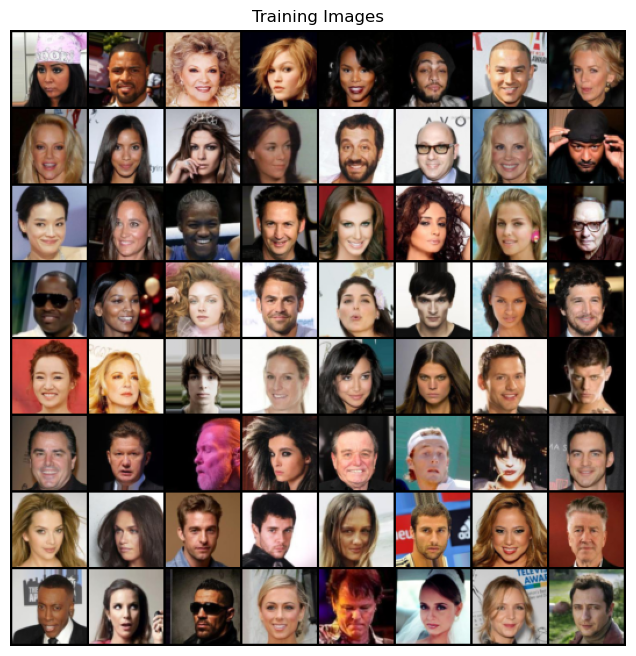

In [9]:
dataset = create_dataset(dataset_name, image_size, load_dataset_in_memory=load_dataset_in_memory)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
criterion = nn.MSELoss()

fixed_noise = torch.randn(8, nc, image_size, image_size, device=device)

In [11]:
model

<module 'models.Diffusion64x64.model' from 'e:\\Master Informatik\\GAN\\models\\Diffusion64x64\\model.py'>

In [12]:
for m_nr, param in enumerate(tqdm(model_params, desc=f"Models")):
    batch_size, size, lr, T, deep_conv = param.get()
    for m in tqdm(range(start_models, models), desc=f"Model Nr {m_nr}"):
        # set_random_seed(m)
        diffusion = model.Diffusion(image_size=image_size, T=T, device=device)
        diff_model = model.UNet(nc=nc, image_size=image_size, device=device, size=size, deep_conv=deep_conv).to(device)
        optimizer = optim.AdamW(diff_model.parameters(), lr=lr)
        path = f"models/{model_name}/model_saves/" \
               f"{dataset_name}-max_per_epoch{max_images_per_epoch}" \
               f"-batch_size{batch_size}-size{size}" \
               f"-lr{lr}-T{T}-deep_conv{deep_conv}"
        torch.save(diff_model.state_dict(), f"{path}/unet-model{m}-epoch0.pkl")
        tqdm_epochs = tqdm(range(1, num_epochs + 1), desc="Epochs")
        for epoch in tqdm_epochs:
            if max_images_per_epoch != 0:
                sampler = torch.utils.data.SubsetRandomSampler(torch.randperm(len(dataset))[:max_images_per_epoch])
                dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=0, sampler=sampler)
            else:
                dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=0)
            tqdm_epoch = tqdm(dataloader, desc=f"Epoch {epoch}")
            for i, (data, _) in enumerate(tqdm_epoch):
                data = data.to(device)
                t = diffusion.sample_timesteps(data.shape[0]).to(device)
                x_t, noise = diffusion.noise_images(data, t)
                predicted_noise = diff_model(x_t, t)
                loss = criterion(noise, predicted_noise)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                tqdm_epoch.set_postfix(Loss=loss.item())
            path = f"models/{model_name}/model_saves/" \
                   f"{dataset_name}-max_per_epoch{max_images_per_epoch}" \
                   f"-batch_size{batch_size}-size{size}" \
                   f"-lr{lr}-T{T}-deep_conv{deep_conv}"
            torch.save(diff_model.state_dict(), f"{path}/unet-model{m}-epoch{epoch}.pkl")
            if epoch % 25 == 0 and epoch > 0:
                sampled_images = diffusion.sample(diff_model, x=fixed_noise)
                plot_images(sampled_images)

Models:   0%|          | 0/1 [00:00<?, ?it/s]

Model Nr 0:   0%|          | 0/4 [00:00<?, ?it/s]

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/15195 [00:00<?, ?it/s]

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/15195 [00:00<?, ?it/s]

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/15195 [00:00<?, ?it/s]

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/15195 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/15195 [00:00<?, ?it/s]